In [1]:
import numpy as np
import pandas as pd
import os

import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='white') 

%matplotlib inline

from statannot import add_stat_annotation

# Load data and assignments from benchmarking results

In [ ]:
data = '../data/cd34_multiome_atac.h5ad'
outdir = '../data/cd34_atac/'
component_key = 'X_svd'

ad = sc.read(data)

In [14]:
labels = pd.read_csv('labels_SEACells_Baran_Supercell.csv', index_col=[0])
labels.head()

,SEACell,Baran,Supercell
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep1#AGGAACCAGCCACATG-1,22,34
cd34_multiome_rep1#AAACAGCCACTGACCG-1,cd34_multiome_rep2#GATTGGCGTGGAGCAA-1,3,15
cd34_multiome_rep1#AAACAGCCATAATCAC-1,cd34_multiome_rep1#AACTAGTGTTCATCTA-1,78,56
cd34_multiome_rep1#AAACATGCAAATTCGT-1,cd34_multiome_rep2#TAACCTAAGGATTGAG-1,49,23
cd34_multiome_rep1#AAACATGCAGCATGTC-1,cd34_multiome_rep1#CCAAGTTAGGACCTCA-1,81,7


# Plot assignments

In [12]:
def plot_ad(ad, label, save_as=None, use_mean=True, ax=None):
    plt.figure(figsize=(4,4))

    atac_metacells = ad.obs[label].unique()
    metacell_colors = pd.Series(sns.color_palette(n_colors=len(atac_metacells)).as_hex(), 
             index=np.random.choice(atac_metacells, len(atac_metacells), False))

    basis = 'X_umap'
    plt.scatter(ad.obsm[basis][:, 0], 
                ad.obsm[basis][:, 1], s=.05, 
                color=metacell_colors[ad.obs[label]])#, edgecolor='black')

    if (atac_metacells[0] in ad.obs_names) and not use_mean:
        print('Using actual metacell positions')
        df = pd.DataFrame(ad.obsm[basis]).set_index(ad.obs_names).loc[atac_metacells]
    else:
        print('Using average position for metacell positions')
        df = pd.DataFrame(ad.obsm[basis]).set_index(ad.obs_names).join(ad.obs[label]).groupby(label).mean()
    
    plt.scatter(df[0], df[1], s=20, 
               color=metacell_colors[df.index], linewidth=0.25,
                edgecolor='black', alpha=1)

    ax = plt.gca()
    ax.set_axis_off()
    if save_as is not None:
        plt.title(save_as)
        plt.savefig(save_as, dpi=150, transparent=True)
    plt.show()
    plt.close()

In [15]:
ad = ad[labels.index]
ad.obs =ad.obs.join(labels)

SEACell
Using average position for metacell positions


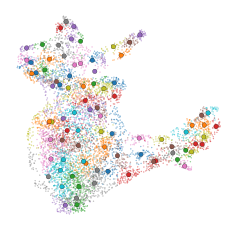

Baran
Using average position for metacell positions


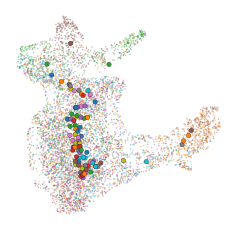

Supercell
Using average position for metacell positions


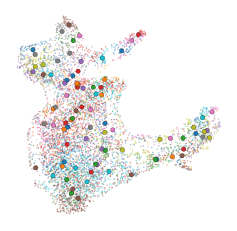

In [16]:
for label in labels:
    print(label)
    plot_ad(ad, label)

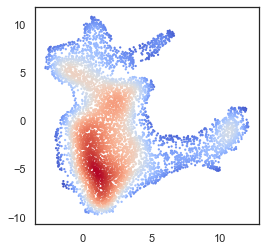

In [36]:
# Plot density of data 
def density_2d(x, y):
    """return x and y and their density z, sorted by their density (smallest to largest)
    :param x, y: np.ndarray: coordinate data
    :return: sorted x, y, and density
    """
    from scipy.stats import gaussian_kde
    
    xy = np.vstack([np.ravel(x), np.ravel(y)])
    z = gaussian_kde(xy)(xy)
    return np.ravel(x), np.ravel(y), z


df = pd.DataFrame(ad.obsm['X_umap'])
df.index = ad.obs_names


x,y,z = density_2d(df[0], df[1])
%matplotlib inline 

plt.figure(figsize=(4,4))
sns.scatterplot(x=x,y=y,hue=z, linewidth=0, s=5, palette='coolwarm', legend=None)
plt.show()
plt.close()


# Compactness

In [18]:
pcs = pd.DataFrame(ad.obsm[component_key]).set_index(ad.obs_names)
pcs.head()

import palantir

dm_res = palantir.utils.run_diffusion_maps(pcs)
dcs = palantir.utils.determine_multiscale_space(dm_res, n_eigs=10)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
/Users/sitarapersad/opt/anaconda3/lib/python3.9/site-packages/palantir-1.0.1-py3.9.egg/palantir/utils.py:56: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


Determing nearest neighbor graph...


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SEACell v.s. Baran: t-test independent samples with Bonferroni correction, P_val=8.610e-20 stat=-1.046e+01
SEACell v.s. Supercell: t-test independent samples with Bonferroni correction, P_val=2.741e-07 stat=-5.503e+00


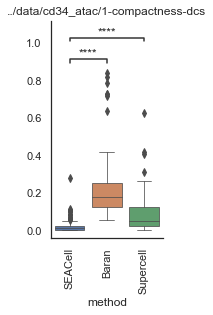

In [40]:
# With outliers
title = outdir+'1-compactness-dcs'
%matplotlib inline
compactness_df = {'values':[],'method':[]}
for column in labels.columns:
    labeled_dcs = dcs.join(labels[column])
    compactness = pd.DataFrame(labeled_dcs.groupby(column).var().mean(1)).rename(columns={0:'compactness'})
    compactness_df['values'] += list(compactness['compactness'].values)
    compactness_df['method'] += [column]*len(compactness['compactness'].values)
compactness_df = pd.DataFrame(compactness_df)

box_pairs = box_pairs = [('SEACell', x) for x in labels1.columns if x != 'SEACell']
sns.set(style='white')
plt.figure(figsize=(2,4))
ax = sns.boxplot(data=compactness_df, x='method', y='values',
                 linewidth=0.75)
add_stat_annotation(ax, data=compactness_df, x='method', y='values', box_pairs=box_pairs,
                    test='t-test_ind', loc='inside', verbose=2)
sns.despine()
plt.ylabel('')
plt.xticks(rotation=90)
plt.title(title)
plt.savefig(title+'.png', dpi=200, transparent=True)
plt.show()
plt.close()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SEACell v.s. Baran: t-test independent samples with Bonferroni correction, P_val=3.726e-23 stat=-1.169e+01
SEACell v.s. Supercell: t-test independent samples with Bonferroni correction, P_val=2.741e-07 stat=-5.503e+00


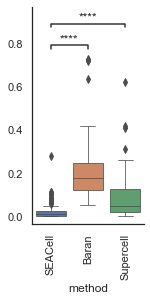

In [41]:
# Remove outliers

compactness_df = compactness_df[compactness_df['values'] < np.percentile(compactness_df['values'], 99)]
box_pairs = box_pairs = [('SEACell', x) for x in labels1.columns if x != 'SEACell']
sns.set(style='white')
plt.figure(figsize=(2,4))
ax = sns.boxplot(data=compactness_df, x='method', y='values',
                 linewidth=0.75)
add_stat_annotation(ax, data=compactness_df, x='method', y='values', box_pairs=box_pairs,
                    test='t-test_ind', loc='inside', verbose=2)
sns.despine()
plt.ylabel('')
plt.xticks(rotation=90)
plt.show()
plt.close()

# Separation

In [42]:
def get_separation(components, label, nth_nbr=1): 
    
    # Compute average per metacell
    metacells_dcs = components.groupby(label).mean()

    from sklearn.neighbors import NearestNeighbors
    neigh = NearestNeighbors(n_neighbors=nth_nbr)
    nbrs = neigh.fit(metacells_dcs)
    dists, nbrs = nbrs.kneighbors()
    dists = pd.DataFrame(dists).set_index(metacells_dcs.index)
    dists.columns += 1

    nbr_cells = np.array(metacells_dcs.index)[nbrs]

    metacells_nbrs = pd.DataFrame(nbr_cells)
    metacells_nbrs.index = metacells_dcs.index
    metacells_nbrs.columns += 1

    return pd.DataFrame(dists[nth_nbr]).rename(columns={1:'separation'})

In [43]:
pcs = pd.DataFrame(ad.obsm[component_key]).set_index(ad.obs_names)
pcs.head()

import palantir

dm_res = palantir.utils.run_diffusion_maps(pcs)
dcs = palantir.utils.determine_multiscale_space(dm_res, n_eigs=10)

Determing nearest neighbor graph...


/Users/sitarapersad/opt/anaconda3/lib/python3.9/site-packages/palantir-1.0.1-py3.9.egg/palantir/utils.py:56: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SEACell v.s. Baran: t-test independent samples with Bonferroni correction, P_val=7.462e-01 stat=8.931e-01
SEACell v.s. Supercell: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-4.467e-01


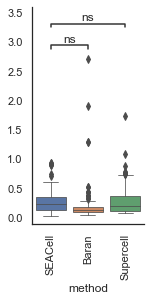

In [44]:
%matplotlib inline

separation_df = {'values':[],'method':[]}
for column in labels:
    labeled_dcs = dcs.join(labels[column])
    separation = get_separation(labeled_dcs, column, 1)
    separation_df['values'] += list(separation['separation'].values)
    separation_df['method'] += [column]*len(separation['separation'].values)
separation_df = pd.DataFrame(separation_df)

box_pairs = box_pairs = [('SEACell', x) for x in labels1.columns if x != 'SEACell']
sns.set(style='white')
plt.figure(figsize=(2,4))
ax = sns.boxplot(data=separation_df, x='method', y='values',
                 linewidth=0.75)
add_stat_annotation(ax, data=separation_df, x='method', y='values', box_pairs=box_pairs,
                    test='t-test_ind', loc='inside', verbose=2)
sns.despine()
plt.ylabel('')
plt.xticks(rotation=90)
plt.show()
plt.close()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SEACell v.s. Baran: t-test independent samples with Bonferroni correction, P_val=5.126e-05 stat=4.331e+00
SEACell v.s. Supercell: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=2.995e-01


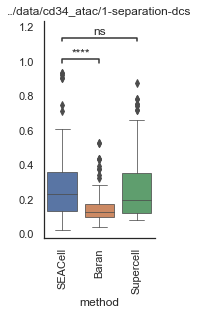

In [46]:
# Remove outliers
title = outdir+'1-separation-dcs'

separation_df = separation_df[separation_df['values'] < np.percentile(separation_df['values'], 99)]
box_pairs = box_pairs = [('SEACell', x) for x in labels1.columns if x != 'SEACell']
sns.set(style='white')
plt.figure(figsize=(2,4))
ax = sns.boxplot(data=separation_df, x='method', y='values',
                 linewidth=0.75)
add_stat_annotation(ax, data=separation_df, x='method', y='values', box_pairs=box_pairs,
                    test='t-test_ind', loc='inside', verbose=2)
sns.despine()
plt.ylabel('')
plt.xticks(rotation=90)
plt.title(title)
plt.savefig(title+'.png', dpi=200, transparent=True)

plt.show()
plt.close()
